**Anomaly Detection in Surveillance Videos**






### **Packages**

In [ ]:
!pip install gradio
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=008b32b1c02a71564a2fd5a2d1f239ce634a937636a7f84dcddb8f8a3da9c352
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import gradio as gr
from moviepy.editor import VideoFileClip
import torch
from torchvision.io import read_image
from torchvision.transforms import Compose, Resize, ToTensor, RandomHorizontalFlip, RandomRotation, ColorJitter
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torchvision.models.video import r3d_18  # 3D ResNet18
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import glob
import random
import torchvision.transforms as transforms
import collections
from sklearn.manifold import TSNE
import seaborn as sns
import wget

### **Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Load Data**

In [ ]:
base_path = '/content/drive/MyDrive/DCSASS Dataset (Simple)'
frames_path = "/content/drive/MyDrive/extracted_frames"
# Path to labels directory
labels_path = os.path.join(base_path, 'Labels')

### **Extracting frames form the videos**

In [ ]:
def extract_frames_fixed_length(dataset_path, output_path, fixed_frames=32):


    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Get categories and skip 'Labels'
    categories = os.listdir(dataset_path)
    if 'Labels' in categories:
        categories.remove('Labels')
    print("Categories:", categories)

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        if os.path.isdir(category_path):
            category_output_path = os.path.join(output_path, category)
            os.makedirs(category_output_path, exist_ok=True)

            for subfolder in os.listdir(category_path):
                subfolder_path = os.path.join(category_path, subfolder)
                if os.path.isdir(subfolder_path):
                    subfolder_output_path = os.path.join(category_output_path, subfolder)
                    os.makedirs(subfolder_output_path, exist_ok=True)

                    for file in os.listdir(subfolder_path):
                        if file.endswith(('.mp4', '.avi', '.mkv')):  # Check video formats
                            video_path = os.path.join(subfolder_path, file)
                            video_name = os.path.splitext(file)[0]
                            video_output_path = os.path.join(subfolder_output_path, video_name)
                            os.makedirs(video_output_path, exist_ok=True)

                            cap = cv2.VideoCapture(video_path)
                            if video_path in subfolder_output_path:
                              continue
                            print(f"Processing video: {video_path}")

                            frames = []
                            while True:
                                ret, frame = cap.read()
                                if not ret:
                                    break
                                frames.append(frame)

                            cap.release()

                            # Handle frame count
                            total_frames = len(frames)

                            if total_frames >= fixed_frames:
                                # Select first `fixed_frames`
                                frames = frames[:fixed_frames]
                            else:
                                # Pad by repeating last frame
                                frames += [frames[-1]] * (fixed_frames - total_frames)

                            # Save frames
                            for i, frame in enumerate(frames):
                                frame_filename = os.path.join(video_output_path, f"frame_{i:04d}.jpg")
                                cv2.imwrite(frame_filename, frame)

                            print(f"Saved {fixed_frames} frames for {file} in {subfolder} under {category}.")

# Extract frames with fixed length
extract_frames_fixed_length(base_path, frames_path, fixed_frames=32)

Categories: ['Stealing', 'Shoplifting', 'Fighting', 'RoadAccidents', 'Shooting', 'Robbery', 'Vandalism', 'Explosion', 'Burglary', 'Abuse', 'Arrest', 'Arson', 'Assault']
Processing video: /content/drive/MyDrive/DCSASS Dataset (Simple)/Stealing/Stealing003_x264.mp4/Stealing003_x264_0.mp4
Saved 32 frames for Stealing003_x264_0.mp4 in Stealing003_x264.mp4 under Stealing.
Processing video: /content/drive/MyDrive/DCSASS Dataset (Simple)/Stealing/Stealing003_x264.mp4/Stealing003_x264_5.mp4
Saved 32 frames for Stealing003_x264_5.mp4 in Stealing003_x264.mp4 under Stealing.
Processing video: /content/drive/MyDrive/DCSASS Dataset (Simple)/Stealing/Stealing003_x264.mp4/Stealing003_x264_17.mp4
Saved 32 frames for Stealing003_x264_17.mp4 in Stealing003_x264.mp4 under Stealing.
Processing video: /content/drive/MyDrive/DCSASS Dataset (Simple)/Stealing/Stealing003_x264.mp4/Stealing003_x264_19.mp4
Saved 32 frames for Stealing003_x264_19.mp4 in Stealing003_x264.mp4 under Stealing.
Processing video: /cont

### **Counting frames and videos**

In [ ]:
def count_frames_in_videos(base_path):

    frame_counts = {}

    # Iterate through each category
    for category in os.listdir(base_path):
        category_path = os.path.join(base_path, category)
        if os.path.isdir(category_path):  # Ensure it's a folder
            frame_counts[category] = {}

            # Iterate through each video in the category
            for video_name in os.listdir(category_path):
                video_path = os.path.join(category_path, video_name)
                if os.path.isdir(video_path):  # Ensure it's a folder
                    frame_counts[category][video_name] = {}

                    # Iterate through each split video in the video folder
                    for split_video_name in os.listdir(video_path):
                        split_video_path = os.path.join(video_path, split_video_name)
                        if os.path.isdir(split_video_path):  # Ensure it's a folder

                            # Count the number of frame files in the split video folder
                            num_frames = len([f for f in os.listdir(split_video_path) if f.endswith('.jpg')])
                            frame_counts[category][video_name][split_video_name] = num_frames

    return frame_counts

frame_counts = count_frames_in_videos(frames_path)

print(frame_counts)

{'Stealing': {'Stealing003_x264.mp4': {'Stealing003_x264_0': 32, 'Stealing003_x264_5': 32, 'Stealing003_x264_17': 32, 'Stealing003_x264_19': 32, 'Stealing003_x264_22': 32, 'Stealing003_x264_24': 32, 'Stealing003_x264_13': 32, 'Stealing003_x264_26': 32, 'Stealing003_x264_23': 32, 'Stealing003_x264_6': 32, 'Stealing003_x264_8': 32, 'Stealing003_x264_14': 32, 'Stealing003_x264_2': 32, 'Stealing003_x264_10': 32, 'Stealing003_x264_31': 32, 'Stealing003_x264_18': 32, 'Stealing003_x264_11': 32, 'Stealing003_x264_4': 32, 'Stealing003_x264_20': 32, 'Stealing003_x264_29': 32, 'Stealing003_x264_9': 32, 'Stealing003_x264_12': 32, 'Stealing003_x264_3': 32, 'Stealing003_x264_27': 32, 'Stealing003_x264_25': 32, 'Stealing003_x264_1': 32, 'Stealing003_x264_15': 32, 'Stealing003_x264_7': 32, 'Stealing003_x264_16': 32, 'Stealing003_x264_28': 32, 'Stealing003_x264_21': 32, 'Stealing003_x264_30': 32}, 'Stealing002_x264.mp4': {'Stealing002_x264_12': 32, 'Stealing002_x264_4': 32, 'Stealing002_x264_30': 32, '

In [ ]:
frame_counts_per_category = {}

for category, videos in frame_counts.items():
    total_frames = 0
    for video_name, splits in videos.items():
        for split_video_name, frame_count in splits.items():
            total_frames += frame_count
    frame_counts_per_category[category] = total_frames


frame_counts_per_category

{'Stealing': 5120,
 'Shoplifting': 5120,
 'Fighting': 5120,
 'RoadAccidents': 5120,
 'Shooting': 5120,
 'Robbery': 5120,
 'Vandalism': 5120,
 'Explosion': 5120,
 'Burglary': 5120,
 'Abuse': 5120,
 'Arrest': 5120,
 'Arson': 5120,
 'Assault': 5120}

In [ ]:
videos_per_category = {}

for category, videos in frame_counts.items():
    # The number of videos is the number of keys under each category
    videos_per_category[category] = len(videos)

videos_per_category

{'Stealing': 5,
 'Shoplifting': 5,
 'Fighting': 5,
 'RoadAccidents': 5,
 'Shooting': 5,
 'Robbery': 5,
 'Vandalism': 5,
 'Explosion': 5,
 'Burglary': 5,
 'Abuse': 5,
 'Arrest': 5,
 'Arson': 5,
 'Assault': 5}

In [ ]:
# Function to get the resolution of the first frame in a directory
def get_frame_resolution(frame_dir):
    # Get the list of frame files in the directory
    frames = [f for f in os.listdir(frame_dir) if f.endswith((".png", ".jpg", ".jpeg"))]
    if not frames:
        print(f"No frames found in {frame_dir}")
        return

    # Sort and pick the first frame (assuming they are named sequentially)
    first_frame_path = os.path.join(frame_dir, sorted(frames)[0])

    # Open the image to get its resolution
    with Image.open(first_frame_path) as img:
        width, height = img.size
        print(f"Sample from {os.path.basename(os.path.dirname(frame_dir))}: {width}x{height}")

# Process one example from each category
for category in os.listdir(frames_path):
    category_path = os.path.join(frames_path, category)

    # Skip if not a directory
    if not os.path.isdir(category_path):
        continue

    # Get the first video folder in the category
    video_folders = [f for f in os.listdir(category_path) if os.path.isdir(os.path.join(category_path, f))]
    if video_folders:
        first_video_folder = os.path.join(category_path, video_folders[0])

        # Get the first frame directory inside the video folder
        frame_dirs = [f for f in os.listdir(first_video_folder) if os.path.isdir(os.path.join(first_video_folder, f))]
        if frame_dirs:
            first_frame_dir = os.path.join(first_video_folder, frame_dirs[0])
            get_frame_resolution(first_frame_dir)
        else:
            print(f"No frame directories found in {first_video_folder}")

Sample from Stealing003_x264.mp4: 320x240
Sample from Shoplifting006_x264.mp4: 320x240
Sample from Fighting005_x264.mp4: 320x240
Sample from RoadAccidents006_x264.mp4: 320x240
Sample from Shooting007_x264.mp4: 320x240
Sample from Robbery001_x264.mp4: 320x240
Sample from Vandalism002_x264.mp4: 320x240
Sample from Explosion006_x264.mp4: 320x240
Sample from Burglary007_x264.mp4: 320x240
Sample from Abuse001_x264.mp4: 320x240
Sample from Arrest002_x264.mp4: 320x240
Sample from Arson003_x264.mp4: 320x240
Sample from Assault002_x264.mp4: 320x240


## **Pre-Processing**

### **Handle the labels for all categories**

In [ ]:
def load_category_dataframes(labels_path):

    category_dataframes = {}

    if os.path.exists(labels_path) and os.path.isdir(labels_path):
        for category in os.listdir(labels_path):
            category_csv_path = os.path.join(labels_path, category)

            # Ensure the file is a CSV
            if os.path.isfile(category_csv_path) and category_csv_path.endswith(".csv"):
                # Read the CSV file into a DataFrame
                category_name = os.path.splitext(category)[0]  # Extract filename without extension
                category_dataframes[category_name] = pd.read_csv(category_csv_path)

    return category_dataframes

category_dataframes = load_category_dataframes(labels_path)

# Print keys and first rows of the DataFrames
for category, dataframe in category_dataframes.items():
    print(f"Category: {category}")
    print(dataframe.head())

Category: Arson
   Arson002_x264_0  Arson  0
0  Arson002_x264_1  Arson  0
1  Arson002_x264_2  Arson  0
2  Arson002_x264_3  Arson  1
3  Arson002_x264_4  Arson  1
4  Arson002_x264_5  Arson  1
Category: Arrest
   Arrest001_x264_0  Arrest  0
0  Arrest001_x264_1  Arrest  0
1  Arrest001_x264_2  Arrest  0
2  Arrest001_x264_3  Arrest  0
3  Arrest001_x264_4  Arrest  0
4  Arrest001_x264_5  Arrest  0
Category: Abuse
   Abuse001_x264_0  Abuse    0
0  Abuse001_x264_1  Abuse  0.0
1  Abuse001_x264_2  Abuse  0.0
2  Abuse001_x264_3  Abuse  0.0
3  Abuse001_x264_4  Abuse  1.0
4  Abuse001_x264_5  Abuse  1.0
Category: Stealing
   Stealing002_x264_0  Stealing  0
0  Stealing002_x264_1  Stealing  0
1  Stealing002_x264_2  Stealing  0
2  Stealing002_x264_3  Stealing  0
3  Stealing002_x264_4  Stealing  0
4  Stealing002_x264_5  Stealing  0
Category: Assault
   Assault002_x264_0  Assault  0
0  Assault002_x264_1  Assault  1
1  Assault002_x264_2  Assault  1
2  Assault002_x264_3  Assault  1
3  Assault002_x264_4  Assa

In [ ]:
category_dataframes['Abuse']

,Abuse001_x264_0,Abuse,0
0,Abuse001_x264_1,Abuse,0.0
1,Abuse001_x264_2,Abuse,0.0
2,Abuse001_x264_3,Abuse,0.0
3,Abuse001_x264_4,Abuse,1.0
4,Abuse001_x264_5,Abuse,1.0
...,...,...,...
1210,Abuse050_x264_27,Abuse,1.0
1211,Abuse050_x264_28,Abuse,1.0
1212,Abuse050_x264_29,Abuse,1.0
1213,Abuse050_x264_30,Abuse,1.0


### **Load the label for all videos**

In [ ]:
# Function to make each video with its label
def generate_label_dict(category_dataframes):
    label_dict = {}
    for category, dataframe in category_dataframes.items():
        for _, row in dataframe.iterrows():
            subvideo_name = row.iloc[0]  # Assuming the first column is the subvideo name
            label = int(row.iloc[-1])   # Assuming the last column is the label
            label_dict[subvideo_name] = label # 0 or 1
    return label_dict

### **Replace missing values with 0 label (Normal video)**

In [ ]:
for category, dataframe in category_dataframes.items():

    print(f"Category: {category})")
    print(f"Number of samples: {len(dataframe)}")
    print(f"Number of null value in the dataframe: {dataframe.isnull().sum().sum()}")

Category: Arson)
Number of samples: 703
Number of null value in the dataframe: 0
Category: Arrest)
Number of samples: 831
Number of null value in the dataframe: 0
Category: Abuse)
Number of samples: 1215
Number of null value in the dataframe: 2
Category: Stealing)
Number of samples: 2047
Number of null value in the dataframe: 0
Category: Assault)
Number of samples: 735
Number of null value in the dataframe: 0
Category: Explosion)
Number of samples: 735
Number of null value in the dataframe: 0
Category: Shoplifting)
Number of samples: 895
Number of null value in the dataframe: 0
Category: Fighting)
Number of samples: 255
Number of null value in the dataframe: 0
Category: Vandalism)
Number of samples: 927
Number of null value in the dataframe: 0
Category: RoadAccidents)
Number of samples: 2421
Number of null value in the dataframe: 0
Category: Burglary)
Number of samples: 1503
Number of null value in the dataframe: 0
Category: Shooting)
Number of samples: 959
Number of null value in the 

In [ ]:
# Replace NaN values in the label column with 0
for category, dataframe in category_dataframes.items():
    dataframe.fillna(0, inplace=True)

In [ ]:
for category, dataframe in category_dataframes.items():

    print(f"Category: {category})")
    print(f"Number of samples: {len(dataframe)}")
    print(f"Number of null value in the dataframe: {dataframe.isnull().sum().sum()}")

Category: Arson)
Number of samples: 703
Number of null value in the dataframe: 0
Category: Arrest)
Number of samples: 831
Number of null value in the dataframe: 0
Category: Abuse)
Number of samples: 1215
Number of null value in the dataframe: 0
Category: Stealing)
Number of samples: 2047
Number of null value in the dataframe: 0
Category: Assault)
Number of samples: 735
Number of null value in the dataframe: 0
Category: Explosion)
Number of samples: 735
Number of null value in the dataframe: 0
Category: Shoplifting)
Number of samples: 895
Number of null value in the dataframe: 0
Category: Fighting)
Number of samples: 255
Number of null value in the dataframe: 0
Category: Vandalism)
Number of samples: 927
Number of null value in the dataframe: 0
Category: RoadAccidents)
Number of samples: 2421
Number of null value in the dataframe: 0
Category: Burglary)
Number of samples: 1503
Number of null value in the dataframe: 0
Category: Shooting)
Number of samples: 959
Number of null value in the 

In [ ]:
def resize_frames(frame_dir, target_size=(256, 256)):
    frames = [f for f in os.listdir(frame_dir) if f.endswith((".png", ".jpg", ".jpeg"))]
    for frame in frames:
        frame_path = os.path.join(frame_dir, frame)
        with Image.open(frame_path) as img:
            resized_frame = img.resize(target_size)
            resized_frame.save(frame_path)

### **Normalize frames range to [0, 1]**

In [ ]:
# Function to normalize colors in frames to the range [0,1]
def normalize_frames(frame_path):
    img = read_image(frame_path).float() / 255.0  # Convert to float and normalize to [0,1]
    return img

## **Data Preparation**

In [ ]:
# # Function to load and process frames from a subvideo folder
# def load_frames(subvideo_path, transform):
#     frames = sorted(os.listdir(subvideo_path))  # Ensure frames are sorted
#     frame_tensors = []
#     for frame in frames:
#         frame_path = os.path.join(subvideo_path, frame)
#         img = read_image(frame_path)  # Read image as tensor
#         if transform:
#             img = transform(img)
#         frame_tensors.append(img)
#     return torch.stack(frame_tensors)  # Stack frames into [T, C, H, W]

In [ ]:
def load_frames(subvideo_path, transform, T=32):
    """Load frames from a subvideo folder, apply transformations, and normalize pixels."""
    frames = sorted(os.listdir(subvideo_path))  # Ensure frames are sorted
    frame_tensors = []
    for frame in frames:
        frame_path = os.path.join(subvideo_path, frame)
        normalized_img = normalize_frames(frame_path)  # Convert to float and normalize to [0,1]

        if transform:
            normalized_img = transform(normalized_img)  # Apply resizing

        frame_tensors.append(normalized_img)

    # Convert list to tensor
    video_tensor = torch.stack(frame_tensors)  # Shape: [T_actual, C, H, W]

    T_actual = video_tensor.shape[0]  # Actual frame count

    # **Handle inconsistencies**
    if T_actual < T:
        # **Pad by repeating the last frame**
        pad_size = T - T_actual
        pad_frames = video_tensor[-1:].repeat(pad_size, 1, 1, 1)
        video_tensor = torch.cat([video_tensor, pad_frames], dim=0)
    elif T_actual > T:
        # **Trim to the first `T` frames**
        video_tensor = video_tensor[:T]

    return video_tensor  # Shape: [T, C, H, W]

In [ ]:
# Function to prepare data for training
def prepare_data(subvideo_paths, label_dict, transform):
    data = []
    for subvideo_path in tqdm(subvideo_paths):
        subvideo_name = os.path.basename(subvideo_path)  # Third-level folder name
        if subvideo_name in label_dict:
            label = label_dict[subvideo_name]
            video_tensor = load_frames(subvideo_path, transform)  # Load frames
            data.append((video_tensor, label))
    return data

In [ ]:
def collect_subvideo_paths(root_dir):
    subvideo_paths = []
    for crime in os.listdir(root_dir):  # Top-level folders (e.g., Abuse, Arson)
        crime_path = os.path.join(root_dir, crime)
        if os.path.isdir(crime_path):
            for full_video in os.listdir(crime_path):  # Second-level folders (e.g., Abuse001_x264.mp4)
                full_video_path = os.path.join(crime_path, full_video)
                if os.path.isdir(full_video_path):
                    for subvideo in os.listdir(full_video_path):  # Third-level folders (e.g., Abuse001_x264_0)
                        subvideo_path = os.path.join(full_video_path, subvideo)
                        if os.path.isdir(subvideo_path):
                            subvideo_paths.append(subvideo_path)
    return subvideo_paths

In [ ]:
# Function to split the dataset into train, validation, and test sets
def split_dataset(subvideo_paths, test_size=0.2, val_size=0.2):
    train_paths, test_paths = train_test_split(subvideo_paths, test_size=test_size, random_state=42)
    train_paths, val_paths = train_test_split(train_paths, test_size=val_size / (1 - test_size), random_state=42)
    return train_paths, val_paths, test_paths

## **Integration**

In [ ]:
label_dict = generate_label_dict(category_dataframes)

# Step 2: Collect all subvideo paths
subvideo_paths = collect_subvideo_paths(frames_path)

# Step 3: Split into train, validation, and test sets
train_paths, val_paths, test_paths = split_dataset(subvideo_paths)

from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, ColorJitter, RandomRotation
# Define image transformations
transform = Compose([
    RandomHorizontalFlip(),
    RandomRotation(degrees=10),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    Resize((112, 112))
])

# Step 4: Prepare data
train_data = prepare_data(train_paths, label_dict, transform)
val_data = prepare_data(val_paths, label_dict, transform)
test_data = prepare_data(test_paths, label_dict, transform)

# Step 5: Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

  0%|          | 3/1248 [00:34<4:00:19, 11.58s/it]


KeyboardInterrupt: 

In [ ]:
# Example: Iterate through the training loader
for batch in train_loader:
    videos, labels = batch
    print(videos.shape, labels)
    break

In [ ]:
len(train_data[0][0])

In [ ]:
len(subvideo_paths)

## **Use and Train 3D ResNet-18 Model**

In [ ]:
class AnomalyDetection3DCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(AnomalyDetection3DCNN, self).__init__()

        # Base Model: 3D ResNet-18
        self.model = r3d_18(pretrained=True)  # Load pre-trained weights

        # Add Dropout
        self.dropout = nn.Dropout(p=0.5)

        # Modify the Fully Connected (FC) Layer
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        x = self.model(x)         # Forward through ResNet-18
        x = self.dropout(x)       # Apply Dropout
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss, and optimizer
model = AnomalyDetection3DCNN(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from torchsummary import summary

# Print model summary
summary(model, input_size=(3, 16, 112, 112))  # (C, T, H, W)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 64, 16, 56, 56]          28,224
       BatchNorm3d-2       [-1, 64, 16, 56, 56]             128
              ReLU-3       [-1, 64, 16, 56, 56]               0
      Conv3DSimple-4       [-1, 64, 16, 56, 56]         110,592
       BatchNorm3d-5       [-1, 64, 16, 56, 56]             128
              ReLU-6       [-1, 64, 16, 56, 56]               0
      Conv3DSimple-7       [-1, 64, 16, 56, 56]         110,592
       BatchNorm3d-8       [-1, 64, 16, 56, 56]             128
              ReLU-9       [-1, 64, 16, 56, 56]               0
       BasicBlock-10       [-1, 64, 16, 56, 56]               0
     Conv3DSimple-11       [-1, 64, 16, 56, 56]         110,592
      BatchNorm3d-12       [-1, 64, 16, 56, 56]             128
             ReLU-13       [-1, 64, 16, 56, 56]               0
     Conv3DSimple-14       [-1, 64, 16,

In [ ]:
epochs = 20

epoch_train_losses = []  # Track per-epoch losses instead of per-batch
epoch_val_losses = []    # Track per-epoch losses instead of per-batch

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    print("-" * 50)

    # Training Phase
    model.train()
    total_train_loss, correct_train = 0, 0
    batch_train_losses = []  # Store losses for this epoch

    for videos, labels in tqdm(train_loader):
        videos, labels = videos.to(device), labels.to(device)
        videos = videos.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()

        # Add gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_train_loss += loss.item()
        batch_train_losses.append(loss.item())
        correct_train += (outputs.argmax(1) == labels).sum().item()

    # Calculate average loss per epoch instead of per batch
    train_loss = total_train_loss / len(train_loader)
    train_acc = correct_train / len(train_loader.dataset)
    epoch_train_losses.append(train_loss)  # Store epoch-level loss

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    # Validation Phase
    model.eval()
    total_val_loss, correct_val = 0, 0
    batch_val_losses = []  # Store losses for this epoch

    with torch.no_grad():
        for videos, labels in val_loader:
            videos, labels = videos.to(device), labels.to(device)
            videos = videos.permute(0, 2, 1, 3, 4)

            outputs = model(videos)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            batch_val_losses.append(loss.item())
            correct_val += (outputs.argmax(1) == labels).sum().item()

    # Calculate average loss per epoch instead of per batch
    val_loss = total_val_loss / len(val_loader)
    val_acc = correct_val / len(val_loader.dataset)
    epoch_val_losses.append(val_loss)  # Store epoch-level loss

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Epoch 1/20
--------------------------------------------------


100%|██████████| 39/39 [00:14<00:00,  2.64it/s]


Train Loss: 0.9317, Train Accuracy: 0.5942
Validation Loss: 0.6573, Validation Accuracy: 0.6241
Epoch 2/20
--------------------------------------------------


100%|██████████| 39/39 [00:14<00:00,  2.72it/s]


Train Loss: 0.6933, Train Accuracy: 0.5829
Validation Loss: 0.8201, Validation Accuracy: 0.4723
Epoch 3/20
--------------------------------------------------


100%|██████████| 39/39 [00:14<00:00,  2.72it/s]


Train Loss: 0.6924, Train Accuracy: 0.5748
Validation Loss: 3.6548, Validation Accuracy: 0.5181
Epoch 4/20
--------------------------------------------------


100%|██████████| 39/39 [00:14<00:00,  2.70it/s]


Train Loss: 0.7019, Train Accuracy: 0.5481
Validation Loss: 0.9184, Validation Accuracy: 0.5325
Epoch 5/20
--------------------------------------------------


100%|██████████| 39/39 [00:14<00:00,  2.72it/s]


Train Loss: 0.7008, Train Accuracy: 0.5764
Validation Loss: 0.9885, Validation Accuracy: 0.6096
Epoch 6/20
--------------------------------------------------


100%|██████████| 39/39 [00:14<00:00,  2.72it/s]


Train Loss: 0.7299, Train Accuracy: 0.5691
Validation Loss: 0.7119, Validation Accuracy: 0.5807
Epoch 7/20
--------------------------------------------------


100%|██████████| 39/39 [00:14<00:00,  2.71it/s]


Train Loss: 0.6939, Train Accuracy: 0.5950
Validation Loss: 0.6222, Validation Accuracy: 0.6506
Epoch 8/20
--------------------------------------------------


100%|██████████| 39/39 [00:14<00:00,  2.71it/s]


Train Loss: 0.6752, Train Accuracy: 0.6217
Validation Loss: 0.7106, Validation Accuracy: 0.5494
Epoch 9/20
--------------------------------------------------


100%|██████████| 39/39 [00:14<00:00,  2.71it/s]


Train Loss: 0.6706, Train Accuracy: 0.6128
Validation Loss: 0.6783, Validation Accuracy: 0.5880
Epoch 10/20
--------------------------------------------------


100%|██████████| 39/39 [00:14<00:00,  2.71it/s]


Train Loss: 0.7129, Train Accuracy: 0.5974
Validation Loss: 0.6782, Validation Accuracy: 0.5157
Epoch 11/20
--------------------------------------------------


100%|██████████| 39/39 [00:14<00:00,  2.71it/s]


Train Loss: 0.6944, Train Accuracy: 0.5918
Validation Loss: 3.3523, Validation Accuracy: 0.5783
Epoch 12/20
--------------------------------------------------


100%|██████████| 39/39 [00:14<00:00,  2.71it/s]


Train Loss: 0.7161, Train Accuracy: 0.5918
Validation Loss: 0.6595, Validation Accuracy: 0.6000
Epoch 13/20
--------------------------------------------------


100%|██████████| 39/39 [00:14<00:00,  2.71it/s]


Train Loss: 0.6882, Train Accuracy: 0.6257
Validation Loss: 0.6467, Validation Accuracy: 0.6361
Epoch 14/20
--------------------------------------------------


100%|██████████| 39/39 [00:14<00:00,  2.71it/s]


Train Loss: 0.6756, Train Accuracy: 0.6362
Validation Loss: 2.5122, Validation Accuracy: 0.5060
Epoch 15/20
--------------------------------------------------


100%|██████████| 39/39 [00:14<00:00,  2.71it/s]


Train Loss: 0.6621, Train Accuracy: 0.6435
Validation Loss: 0.6212, Validation Accuracy: 0.6554
Epoch 16/20
--------------------------------------------------


100%|██████████| 39/39 [00:14<00:00,  2.72it/s]


Train Loss: 0.6448, Train Accuracy: 0.6580
Validation Loss: 0.6077, Validation Accuracy: 0.6699
Epoch 17/20
--------------------------------------------------


100%|██████████| 39/39 [00:14<00:00,  2.71it/s]


Train Loss: 0.6466, Train Accuracy: 0.6500
Validation Loss: 0.6594, Validation Accuracy: 0.6410
Epoch 18/20
--------------------------------------------------


100%|██████████| 39/39 [00:14<00:00,  2.72it/s]


Train Loss: 0.6084, Train Accuracy: 0.6686
Validation Loss: 0.5818, Validation Accuracy: 0.7060
Epoch 19/20
--------------------------------------------------


100%|██████████| 39/39 [00:14<00:00,  2.71it/s]


Train Loss: 0.6094, Train Accuracy: 0.6718
Validation Loss: 1.4786, Validation Accuracy: 0.5277
Epoch 20/20
--------------------------------------------------


100%|██████████| 39/39 [00:14<00:00,  2.71it/s]


Train Loss: 0.6060, Train Accuracy: 0.6799
Validation Loss: 0.5932, Validation Accuracy: 0.6723


## Save the model

In [ ]:
# Define path in Google Drive
save_path = "/content/drive/MyDrive/anomaly_detection_3dcnn.pth"

# Save model weights
torch.save(model.state_dict(), save_path)

print(f"Model saved to {save_path}")


Model saved to /content/drive/MyDrive/anomaly_detection_3dcnn.pth


## Load the model

In [ ]:
# Define same model architecture
model = AnomalyDetection3DCNN(num_classes=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load saved weights from Google Drive
load_path = "/content/drive/MyDrive/anomaly_detection_3dcnn.pth"
model.load_state_dict(torch.load(load_path))
model.to(device)
model.eval()

print("Model loaded successfully!")

<ipython-input-14-596a314781e2>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_path))


Model loaded successfully!


## **Model Evaluation**

In [ ]:
model.eval()  # Set to evaluation mode

# Test Phase
total_test_loss, correct_test = 0, 0

with torch.no_grad():
    for videos, labels in test_loader:
        videos, labels = videos.to(device), labels.to(device)

        # Permute the videos to [Batch_Size, Channels, Time, Height, Width]
        videos = videos.permute(0, 2, 1, 3, 4)  # Swap Time (T) and Channels (C)

        outputs = model(videos)
        loss = criterion(outputs, labels)

        total_test_loss += loss.item()
        correct_test += (outputs.argmax(1) == labels).sum().item()

test_loss = total_test_loss / len(test_loader)
test_acc = correct_test / len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Test Loss: 0.6313, Test Accuracy: 0.6683


In [ ]:
all_preds = []
all_labels = []

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for videos, labels in test_loader:
        # Move data to device
        videos, labels = videos.to(device), labels.to(device)

        # Permute the input to match the expected shape
        videos = videos.permute(0, 2, 1, 3, 4)  # [B, C, T, H, W]

        # Get model predictions
        outputs = model(videos)
        preds = outputs.argmax(1)  # Get predicted class (0 or 1)

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
# Compute precision, recall, and F1-score
precision = precision_score(all_labels, all_preds, average='binary') # 'binary' because our task is binary classification
recall = recall_score(all_labels, all_preds, average='binary')
f1 = f1_score(all_labels, all_preds, average='binary')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Precision: 0.67
Recall: 0.43
F1-score: 0.52


In [ ]:

# Print classification report
print(classification_report(all_labels, all_preds, target_names=['Normal', 'Anomaly']))


              precision    recall  f1-score   support

      Normal       0.67      0.84      0.75       238
     Anomaly       0.67      0.43      0.52       175

    accuracy                           0.67       413
   macro avg       0.67      0.64      0.63       413
weighted avg       0.67      0.67      0.65       413



## Model Visualization

### **confusion matrix**

Confusion Matrix:
[[201  37]
 [100  75]]


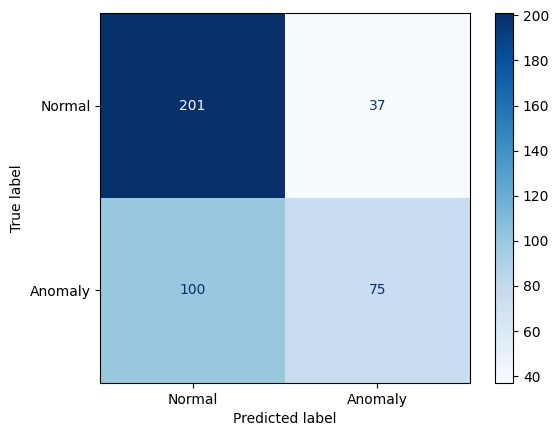

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optionally display it visually
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Draw Training & Validation Loss

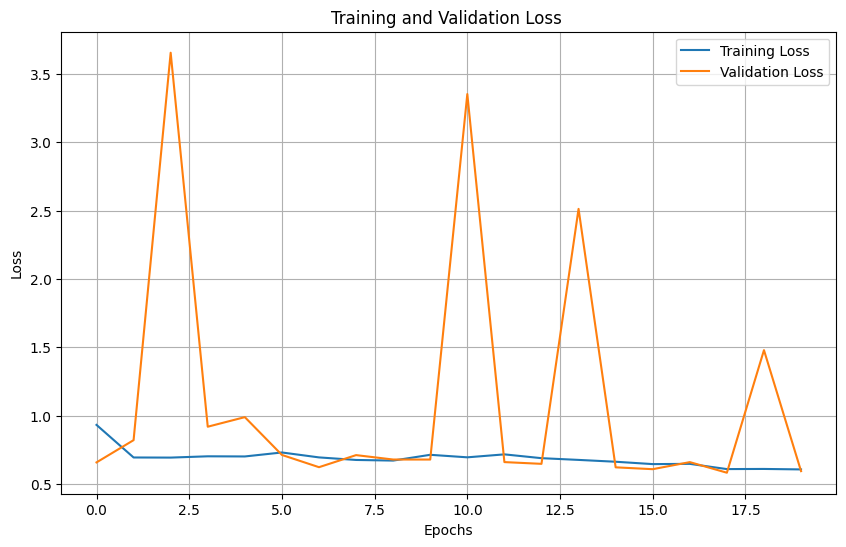

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epoch_train_losses, label='Training Loss')
plt.plot(epoch_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss ')
plt.grid(True)
plt.show()

### Drow t-SNE Visualization

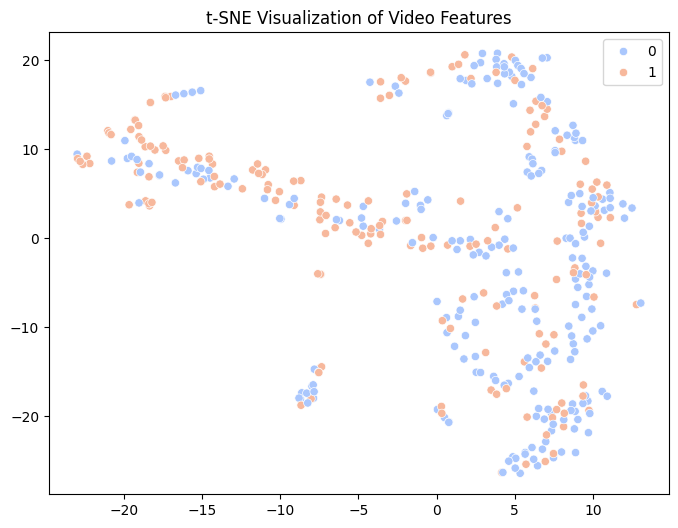

In [ ]:
# Extract features before the FC layer
model.eval()
features = []
labels = []

with torch.no_grad():
    for videos, lbls in test_loader:
        videos = videos.to(device)

        # Permute the input to match the expected shape
        videos = videos.permute(0, 2, 1, 3, 4)  # [B, C, T, H, W]

        lbls = lbls.numpy()
        for layer in list(model.model.children())[:-1]:  # Iterate through layers
          videos = layer(videos)

        # Reshape the features to 2D before appending
        features.append(videos.cpu().numpy().reshape(videos.shape[0], -1))
        labels.extend(lbls)

# Concatenate features
features = np.concatenate(features, axis=0)


# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embedded = tsne.fit_transform(features)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedded[:, 0], y=embedded[:, 1], hue=labels, palette="coolwarm")
plt.title("t-SNE Visualization of Video Features")
plt.show()

### Track Predictions on lebels

In [ ]:
misclassified_videos = []
misclassified_labels = []
misclassified_preds = []

model.eval()
with torch.no_grad():
    for videos, labels in test_loader:
        videos, labels = videos.to(device), labels.to(device)
        videos = videos.permute(0, 2, 1, 3, 4)  # [B, C, T, H, W]

        outputs = model(videos)
        preds = outputs.argmax(1)

        # Identify misclassified samples
        for i in range(len(labels)):
            if preds[i] != labels[i]:  # If prediction is incorrect
                misclassified_videos.append(videos[i].cpu())
                misclassified_labels.append(labels[i].cpu().item())
                misclassified_preds.append(preds[i].cpu().item())


In [ ]:
# Dictionary to track confusion statistics
confusion_tracker = {}  # {true_label: {predicted_label: count}}

model.eval()
with torch.no_grad():
    # Select a random subset of test videos
    test_videos = random.sample(list(test_loader), min(len(test_loader), 20))  # Pick 20 random test batches

    for videos, labels in test_videos:
        videos, labels = videos.to(device), labels.to(device)
        videos = videos.permute(0, 2, 1, 3, 4)  # [B, C, T, H, W]

        outputs = model(videos)
        preds = outputs.argmax(1)  # Get predicted labels

        # Track misclassified samples
        for i in range(len(labels)):
            true_label = labels[i].item()
            pred_label = preds[i].item()

            # If prediction is incorrect, log it
            if true_label != pred_label:
                if true_label not in confusion_tracker:
                    confusion_tracker[true_label] = {}
                if pred_label not in confusion_tracker[true_label]:
                    confusion_tracker[true_label][pred_label] = 0
                confusion_tracker[true_label][pred_label] += 1


In [ ]:
# Convert confusion data into a DataFrame for better visualization
confusion_data = []
for true_label, pred_dict in confusion_tracker.items():
    for pred_label, count in pred_dict.items():
        confusion_data.append([true_label, pred_label, count])

df_confusion = pd.DataFrame(confusion_data, columns=["True Label", "Predicted Label", "Count"])
df_confusion = df_confusion.sort_values(by="Count", ascending=False)

df_confusion

,True Label,Predicted Label,Count
1,1,0,100
0,0,1,37


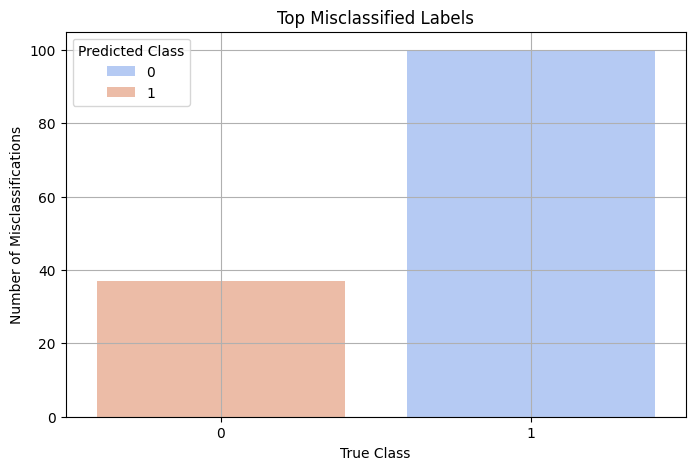

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df_confusion.head(5), x="True Label", y="Count", hue="Predicted Label", palette="coolwarm")
plt.xlabel("True Class")
plt.ylabel("Number of Misclassifications")
plt.title("Top Misclassified Labels")
plt.legend(title="Predicted Class")
plt.grid()
plt.show()

### Track Predictions for All Categories

In [ ]:
def get_category_from_subvideopath(subvideo_path):
    """
    Example subvideo_path:
    .../extracted_frames/Abuse/Abuse001_x264/Abuse001_x264_0
         ^-----------------^ category is "Abuse"
    """
    # go up two levels
    second_level = os.path.dirname(subvideo_path)          #  .../Abuse/Abuse001_x264
    category     = os.path.basename(os.path.dirname(second_level))  # "Abuse"
    return category


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

category_stats = collections.defaultdict(
    lambda: {"total": 0, "correct": 0, "misclassified_as_0": 0, "misclassified_as_1": 0}
)

all_preds = []
all_labels = []
all_categories = []

model.eval()
with torch.no_grad():
    for i, (video_tensor, true_label) in enumerate(test_data):
        subvideo_path = test_paths[i]
        category = get_category_from_subvideopath(subvideo_path)

        # Move data to device. The shape is [T, C, H, W], so we must add batch dimension = 1
        # and permute to [1, C, T, H, W].
        video_tensor = video_tensor.unsqueeze(0).permute(0, 2, 1, 3, 4).to(device)
        true_label   = torch.tensor(true_label).to(device)

        # Run forward pass
        outputs = model(video_tensor)              # shape [1, 2]
        pred    = torch.argmax(outputs, dim=1)     # shape [1]
        pred    = pred.item()                      # integer 0 or 1
        tlab    = true_label.item()

        # Record overall stats
        all_preds.append(pred)
        all_labels.append(tlab)
        all_categories.append(category)

        # Category-level stats
        category_stats[category]["total"] += 1
        if pred == tlab:
            category_stats[category]["correct"] += 1
        else:
            if pred == 0:
                category_stats[category]["misclassified_as_0"] += 1
            else:
                category_stats[category]["misclassified_as_1"] += 1

# Compute overall accuracy
correct_count = sum(1 for i in range(len(all_labels)) if all_preds[i] == all_labels[i])
overall_acc   = correct_count / len(all_labels)
print(f"Overall Test Accuracy (second pass) = {overall_acc:.3f}")


Overall Test Accuracy (second pass) = 0.668


In [ ]:
category_summary = []
for cat, stats in category_stats.items():
    total   = stats["total"]
    correct = stats["correct"]
    acc     = correct / total if total > 0 else 0

    m0 = stats["misclassified_as_0"]
    m1 = stats["misclassified_as_1"]

    # figure out which label is most frequent for misclass
    if m0 > m1:
        most_miss_label = 0
        most_miss_count = m0
    elif m1 > m0:
        most_miss_label = 1
        most_miss_count = m1
    else:
        most_miss_label = "N/A"
        most_miss_count = 0

    category_summary.append({
        "Category": cat,
        "Total": total,
        "Correct": correct,
        "Accuracy": round(acc, 3),
        "Misclassified_As_0": m0,
        "Misclassified_As_1": m1,
        "Most_Misclass_Label": most_miss_label,
        "Misclass_Count": most_miss_count
    })

df_category_summary = pd.DataFrame(category_summary)
df_category_summary = df_category_summary.sort_values("Accuracy", ascending=False)
df_category_summary


,Category,Total,Correct,Accuracy,Misclassified_As_0,Misclassified_As_1,Most_Misclass_Label,Misclass_Count
1,Fighting,35,29,0.829,5,1,0,5
6,Shooting,28,23,0.821,4,1,0,4
2,RoadAccidents,38,31,0.816,6,1,0,6
10,Explosion,22,17,0.773,4,1,0,4
12,Robbery,25,19,0.760,5,1,0,5
5,Arrest,28,21,0.750,6,1,0,6
8,Shoplifting,37,25,0.676,9,3,0,9
4,Assault,34,23,0.676,6,5,0,6
9,Vandalism,34,20,0.588,8,6,0,8
7,Abuse,40,23,0.575,11,6,0,11


### Plot the Misclassification and Accuracy for each category

<ipython-input-99-3cb5cc67c761>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


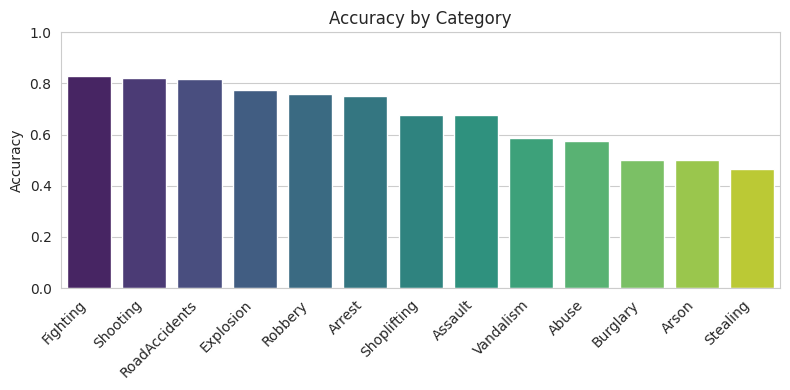

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 4))

# Make sure df_category_summary is sorted by Accuracy descending, for instance
df_sorted = df_category_summary.sort_values("Accuracy", ascending=False)

sns.barplot(
    data=df_sorted,
    x="Category",
    y="Accuracy",
    palette="viridis"
)

plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.title("Accuracy by Category")
plt.xlabel("")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()


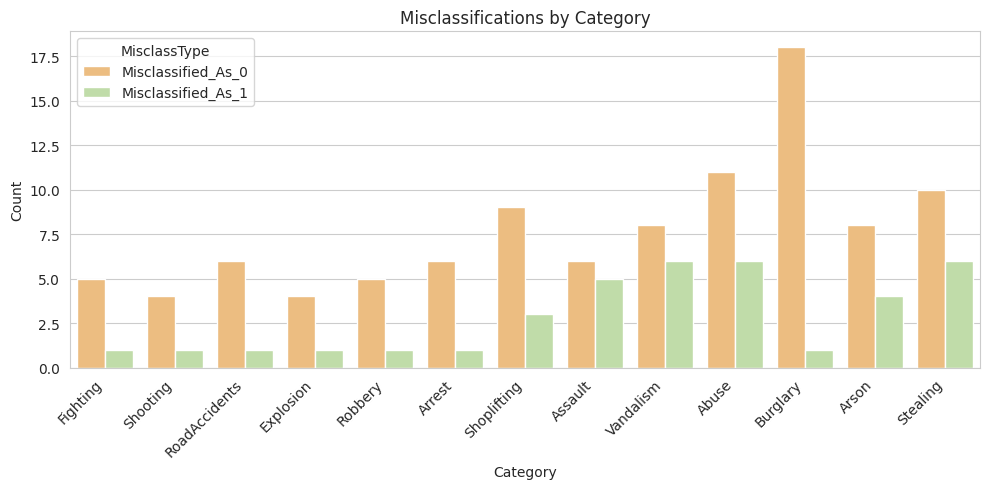

In [ ]:
# 1) Keep only the columns we need.
df_mis = df_category_summary[["Category","Misclassified_As_0","Misclassified_As_1"]].copy()

# 2) Convert from wide to long format
df_melted = df_mis.melt(
    id_vars="Category",
    var_name="MisclassType",
    value_name="Count"
)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=df_melted,
    x="Category",
    y="Count",
    hue="MisclassType",
    palette="Spectral"
)
plt.title("Misclassifications by Category")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Prediction

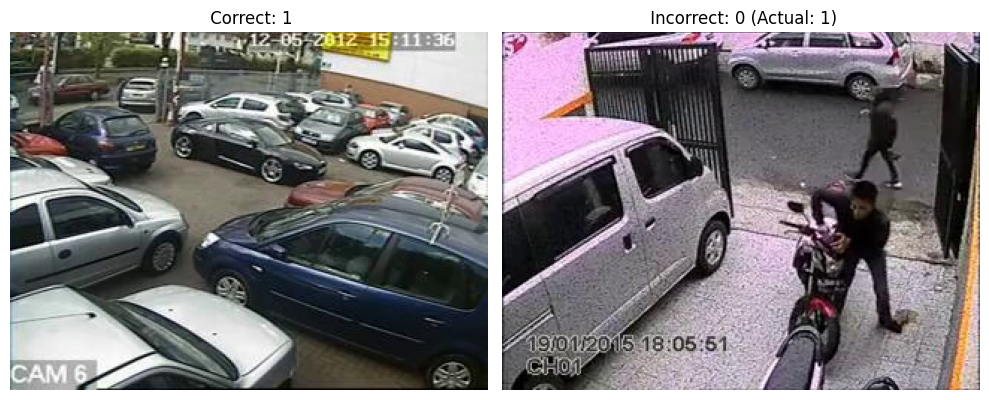

In [ ]:
# Define the test dataset path
test_folder = "/content/drive/MyDrive/DCSASS Dataset (Simple)"  # Change to your actual test dataset path
test_video_paths = glob.glob(f"{test_folder}/**/*.mp4", recursive=True)

# Get indices of correct and incorrect predictions
correct_indices = np.where(np.array(all_preds) == np.array(all_labels))[0]
incorrect_indices = np.where(np.array(all_preds) != np.array(all_labels))[0]

# Ensure there are samples available
correct_sample = random.choice(correct_indices)
incorrect_sample = random.choice(incorrect_indices)

# Function to extract and return a frame from a video
def get_video_frame(video_paths, index):

    video_path = video_paths[index]
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()

    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        return frame
    return None

# Get frames
correct_frame = get_video_frame(test_video_paths, correct_sample)
incorrect_frame = get_video_frame(test_video_paths, incorrect_sample)

# Plot side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

if correct_frame is not None:
    axes[0].imshow(correct_frame)
    axes[0].set_title(f" Correct: {all_preds[correct_sample]}")
    axes[0].axis("off")
else:
    axes[0].set_title("No Correct Predictions Found")
    axes[0].axis("off")

if incorrect_frame is not None:
    axes[1].imshow(incorrect_frame)
    axes[1].set_title(f" Incorrect: {all_preds[incorrect_sample]} (Actual: {all_labels[incorrect_sample]})")
    axes[1].axis("off")
else:
    axes[1].set_title("No Incorrect Predictions Found")
    axes[1].axis("off")

plt.tight_layout()
plt.show()


## Gradio Interface ⭐

In [ ]:

# Load the saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AnomalyDetection3DCNN(num_classes=2)
load_path = "/content/drive/MyDrive/anomaly_detection_3dcnn.pth"
model.load_state_dict(torch.load(load_path, map_location=device))
model.to(device)
model.eval()

# Define preprocessing transformations
transform = Compose([
    Resize((112, 112)),
    RandomHorizontalFlip(),
    RandomRotation(degrees=10),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
])

# Function to extract frames from video
def extract_frames(video_path, num_frames=32):
    clip = VideoFileClip(video_path)
    frames = []
    total_frames = int(clip.fps * clip.duration)

    frame_indices = np.linspace(0, total_frames - 1, num_frames).astype(int)

    for idx in frame_indices:
        frame = clip.get_frame(idx / clip.fps)  # Get frame at timestamp
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        frame = Image.fromarray(frame)
        frame = transform(frame)  # Apply transformations
        frames.append(np.array(frame))

    clip.close()
    return torch.tensor(np.array(frames)).permute(3, 0, 1, 2).unsqueeze(0)  # Convert to model format

# Function to make predictions
def predict_anomaly(video_path):
    video_tensor = extract_frames(video_path).to(device).float() / 255.0  # Normalize

    with torch.no_grad():
        output = model(video_tensor)
        predicted_label = torch.argmax(output, dim=1).item()
        predicted_probability = torch.softmax(output, dim=1)[0][predicted_label].item()

    label_names = {0: "Normal 🌟", 1: "Anomaly 🔥"}
    return f"The video is classified as '{label_names[predicted_label]}' with a confidence score of: {predicted_probability*100:.2f}%"

# Gradio interface
iface = gr.Interface(
    fn=predict_anomaly,
    inputs=gr.Video(label="Upload a Video 🎥"),
    outputs=gr.Textbox(label="Prediction Result 📊"),
    title="Video Anomaly Detection 🎬",
    description="👁️‍🗨️ This tool analyzes uploaded videos to detect anomalous behaviors. Upload a video and the AI will assess if any unusual activity is detected, providing the results with a confidence level. 🕵️",
    theme="huggingface",
    allow_flagging="never"
)

iface.launch(debug=True)  # Set show_flag to False to remove the flag button

  warnings.warn(

  warnings.warn(msg)

  model.load_state_dict(torch.load(load_path, map_location=device))


Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")

  warnings.warn(



Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ad3bab2c6f08a5a7b2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://ad3bab2c6f08a5a7b2.gradio.live
